# DMT Startup Shear: Stress Overshoot and Structure Breakdown

## Learning Objectives

- Understand stress overshoot physics in thixotropic materials
- Model structure breakdown during startup shear
- Apply NLSQ + Bayesian workflow to transient protocols
- Analyze the role of Maxwell elasticity in overshoot behavior

## Prerequisites

- Notebook 01: DMT flow curves and calibration

## Runtime Estimate

- CPU: ~3-5 minutes
- GPU: ~2-3 minutes

## Setup

In [1]:
# Colab setup
import sys

if "google.colab" in sys.modules:
    !pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "1"

In [2]:
# Imports
from rheojax.core.jax_config import safe_import_jax, verify_float64

jax, jnp = safe_import_jax()
verify_float64()

import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from pathlib import Path

from rheojax.models import DMTLocal

%matplotlib inline

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"Float64 enabled: {jax.config.read('jax_enable_x64')}")

JAX version: 0.8.2
JAX devices: [CpuDevice(id=0)]
Float64 enabled: True


## Theory: Startup Shear in DMT Model

### Governing Equations

During startup shear at constant rate $\dot{\gamma}$, the DMT model with Maxwell elasticity evolves as:

**Stress evolution (Maxwell backbone):**
$$
\frac{d\sigma}{dt} = G \dot{\gamma} - \frac{\sigma}{\theta_1(\lambda)}
$$

where $\theta_1(\lambda) = \eta(\lambda)/G$ is the structure-dependent relaxation time.

**Structure evolution:**
$$
\frac{d\lambda}{dt} = \frac{1 - \lambda}{t_{eq}} - \frac{a \lambda |\dot{\gamma}|^c}{t_{eq}}
$$

**Viscosity (exponential closure):**
$$
\eta(\lambda) = \eta_\infty \left(\frac{\eta_0}{\eta_\infty}\right)^\lambda
$$

### Stress Overshoot Mechanism

1. **Initial loading**: At $t=0$, $\lambda=1$ (fully structured), $\sigma=0$
2. **Elastic buildup**: Stress increases rapidly as $\sigma \approx G \dot{\gamma} t$
3. **Structure breakdown**: $\lambda$ decreases due to shear-induced rejuvenation
4. **Viscosity drop**: $\eta(\lambda)$ decreases, relaxation time $\theta_1$ shortens
5. **Overshoot**: Peak stress $\sigma_{peak}$ occurs when relaxation catches up to loading
6. **Steady state**: $\sigma \to \sigma_{ss}$, $\lambda \to \lambda_{ss}$

**Key physics**: Stress overshoot requires elastic storage (Maxwell backbone). Without elasticity (`include_elasticity=False`), stress increases monotonically to steady state.

## Data Generation

In [3]:
# Calibrated parameters from emulsion φ=0.80 flow curve (Notebook 01)
calib_params = {
    "eta_0": 1.5e4,
    "eta_inf": 0.3,
    "a": 0.8,
    "c": 0.7,
    "G0": 500.0,
    "m_G": 1.0,
    "t_eq": 50.0,
}

# Create DMT model with Maxwell elasticity
model_true = DMTLocal(closure="exponential", include_elasticity=True)

# Set calibrated parameters
for name, value in calib_params.items():
    model_true.parameters[name].value = value

print("True model parameters:")
for name, param in model_true.parameters.items():
    print(f"  {name}: {param.value:.4g}")

True model parameters:
  eta_0: 1.5e+04
  eta_inf: 0.3
  G0: 500
  m_G: 1
  t_eq: 50
  a: 0.8
  c: 0.7


In [4]:
# Generate startup shear data at 4 shear rates
gamma_dots = jnp.array([0.1, 1.0, 10.0, 100.0])
t_end = 200.0
dt=1.0

# Storage for synthetic data
startup_data = {}

np.random.seed(42)

for gamma_dot in gamma_dots:
    # Simulate startup
    t, stress, fluidity = model_true.simulate_startup(
        gamma_dot=float(gamma_dot),
        t_end=t_end,
        dt=dt,
    )
    
    # Add 3% Gaussian noise
    noise_level = 0.03
    stress_noisy = stress + noise_level * jnp.std(stress) * np.random.randn(len(stress))
    
    startup_data[float(gamma_dot)] = {
        "t": t,
        "stress": stress,
        "stress_noisy": stress_noisy,
        "fluidity": fluidity,
    }

print(f"Generated startup data at {len(gamma_dots)} shear rates")

Generated startup data at 4 shear rates


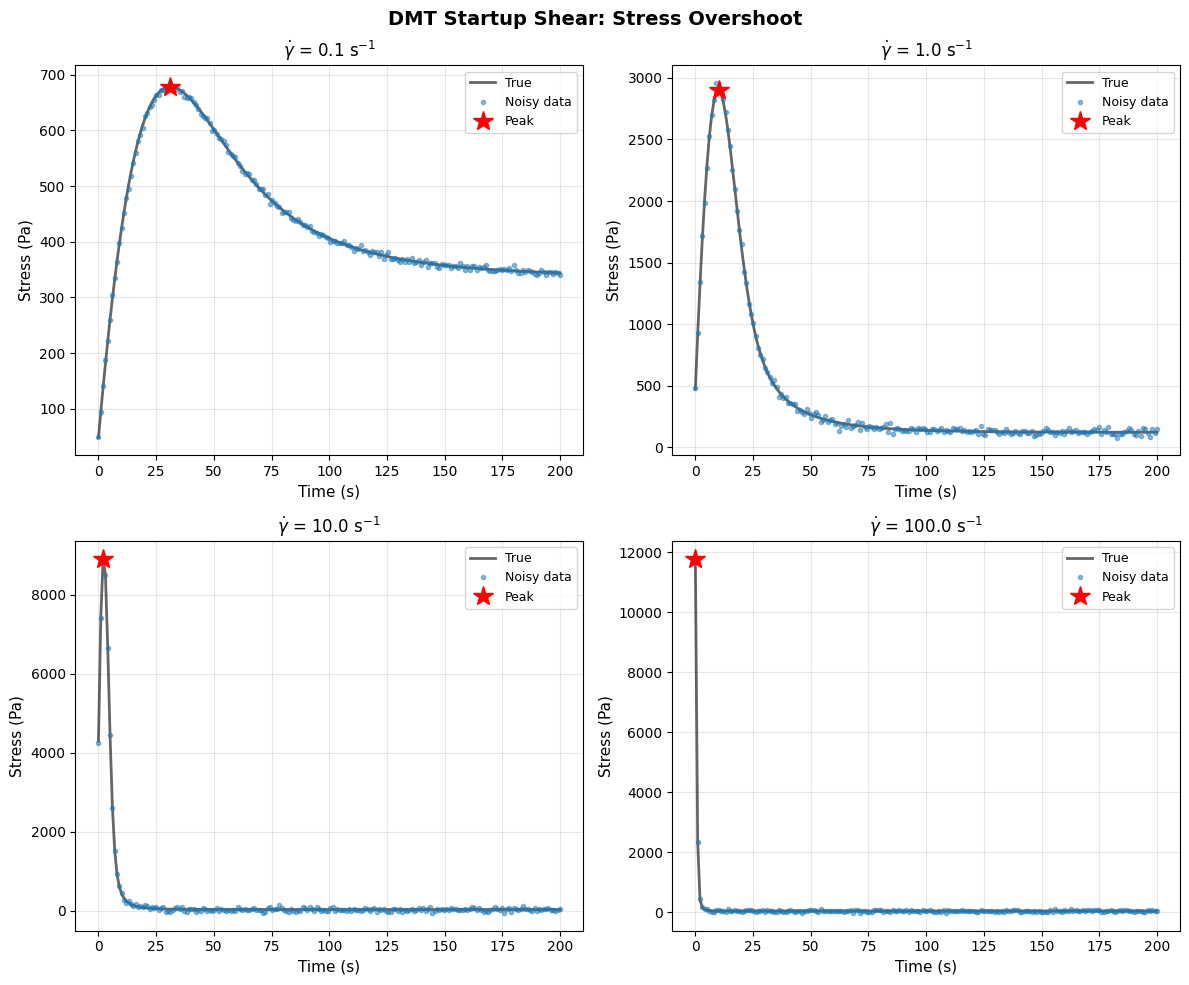

In [5]:
# Plot all startup curves
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, gamma_dot in enumerate(gamma_dots):
    data = startup_data[float(gamma_dot)]
    ax = axes[idx]
    
    ax.plot(data["t"], data["stress"], "k-", linewidth=2, label="True", alpha=0.6)
    ax.plot(data["t"], data["stress_noisy"], "o", markersize=3, alpha=0.5, label="Noisy data")
    
    # Mark overshoot peak
    peak_idx = jnp.argmax(data["stress"])
    ax.plot(data["t"][peak_idx], data["stress"][peak_idx], "r*", markersize=15, label="Peak")
    
    ax.set_xlabel("Time (s)", fontsize=11)
    ax.set_ylabel("Stress (Pa)", fontsize=11)
    ax.set_title(f"$\\dot{{\\gamma}}$ = {gamma_dot:.1f} s$^{{-1}}$", fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

fig.suptitle("DMT Startup Shear: Stress Overshoot", fontsize=14, fontweight="bold")
plt.tight_layout()
display(fig)
plt.close(fig)

## NLSQ Fitting

Fit to a single shear rate ($\dot{\gamma} = 10.0$ s$^{-1}$) using NLSQ optimization.

In [6]:
# Select single shear rate for fitting
gamma_dot_fit = 10.0
data_fit = startup_data[gamma_dot_fit]

t_fit = data_fit["t"]
stress_fit = data_fit["stress_noisy"]

print(f"Fitting to startup data at γ̇ = {gamma_dot_fit} s⁻¹")
print(f"Data points: {len(t_fit)}")

Fitting to startup data at γ̇ = 10.0 s⁻¹
Data points: 200


In [7]:
# Create fresh model for fitting
model_fit = DMTLocal(closure="exponential", include_elasticity=True)

# Helper function for computing fit quality
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

# NLSQ fit
model_fit.fit(
    t_fit,
    stress_fit,
    test_mode="startup",
    gamma_dot=gamma_dot_fit,
)

# Compute R²
stress_pred = model_fit.predict(t_fit, test_mode="startup", gamma_dot=gamma_dot_fit)
metrics = compute_fit_quality(stress_fit, stress_pred)

print("\nNLSQ fitting complete")
print(f"R² = {metrics['R2']:.6f}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=6.401173s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=31 | final_cost=0.0874 | elapsed=6.401s | final_gradient_norm=10.0025



NLSQ fitting complete
R² = 0.999126


In [8]:
# Compare true vs fitted parameters
print("\nParameter comparison:")
print(f"{'Parameter':<10} {'True':>12} {'Fitted':>12} {'Rel. Error':>12}")
print("-" * 50)

for name in calib_params.keys():
    true_val = calib_params[name]
    fitted_val = model_fit.parameters[name].value
    rel_error = abs(fitted_val - true_val) / true_val * 100
    print(f"{name:<10} {true_val:>12.4g} {fitted_val:>12.4g} {rel_error:>11.2f}%")


Parameter comparison:
Parameter          True       Fitted   Rel. Error
--------------------------------------------------
eta_0           1.5e+04    1.395e+04        7.01%
eta_inf             0.3         1.32      340.01%
a                   0.8        1.121       40.18%
c                   0.7         1.14       62.81%
G0                  500        483.2        3.37%
m_G                   1       0.6615       33.85%
t_eq                 50        171.6      243.20%


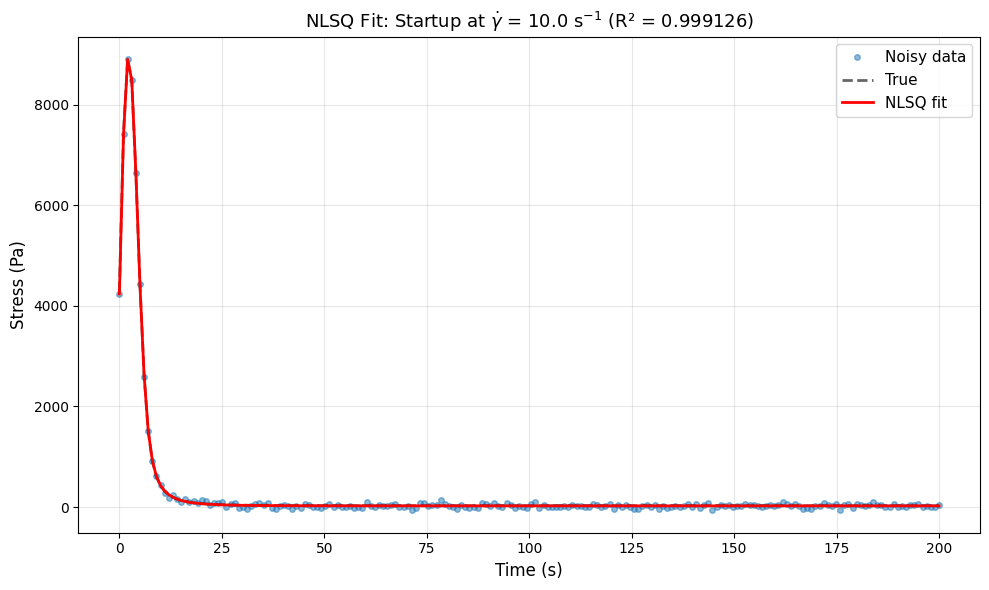

In [9]:
# Plot fitted vs data
stress_pred = model_fit.predict(t_fit, test_mode="startup", gamma_dot=gamma_dot_fit)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_fit, stress_fit, "o", markersize=4, alpha=0.5, label="Noisy data")
ax.plot(t_fit, data_fit["stress"], "k--", linewidth=2, alpha=0.6, label="True")
ax.plot(t_fit, stress_pred, "r-", linewidth=2, label="NLSQ fit")

ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Stress (Pa)", fontsize=12)
ax.set_title(f"NLSQ Fit: Startup at $\\dot{{\\gamma}}$ = {gamma_dot_fit} s$^{{-1}}$ (R² = {metrics['R2']:.6f})", fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian Inference

Warm-start from NLSQ and run NUTS to quantify parameter uncertainty.

In [10]:
# Bayesian inference with warm-start
# Set protocol-specific attributes for startup
model_fit._gamma_dot_applied = gamma_dot_fit
model_fit._startup_lam_init = 1.0

result_bayes = model_fit.fit_bayesian(
    t_fit,
    stress_fit,
    test_mode="startup",
    num_warmup=200,
    num_samples=500,
    num_chains=1,
    seed=42,
)

print("Bayesian inference complete")

/Users/b80985/Projects/rheojax/rheojax/core/base.py:457: RuntimeWarning: Warm-started NUTS initialization failed; retrying with uniform init.
  result = super().fit_bayesian(


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<06:32,  1.78it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   4%|▎         | 25/700 [00:00<00:13, 49.82it/s, 1 steps of size 1.95e-30. acc. prob=0.00]

warmup:   9%|▉         | 63/700 [00:00<00:05, 121.98it/s, 7 steps of size 2.37e-46. acc. prob=0.21]

warmup:  12%|█▏        | 87/700 [00:01<00:05, 113.06it/s, 3 steps of size 9.24e-41. acc. prob=0.43]

warmup:  15%|█▌        | 106/700 [00:01<00:07, 74.89it/s, 63 steps of size 2.44e-37. acc. prob=0.53]

warmup:  18%|█▊        | 127/700 [00:01<00:06, 94.20it/s, 7 steps of size 4.34e-37. acc. prob=0.61] 

warmup:  21%|██        | 145/700 [00:01<00:05, 106.05it/s, 31 steps of size 6.10e-37. acc. prob=0.66]

warmup:  24%|██▍       | 168/700 [00:01<00:04, 123.20it/s, 127 steps of size 1.14e-35. acc. prob=0.70]

warmup:  26%|██▋       | 185/700 [00:02<00:06, 82.73it/s, 1 steps of size 1.66e-35. acc. prob=0.73]   

sample:  29%|██▉       | 202/700 [00:02<00:05, 95.93it/s, 3 steps of size 1.67e-35. acc. prob=1.00]

sample:  32%|███▏      | 226/700 [00:02<00:03, 120.58it/s, 1 steps of size 1.67e-35. acc. prob=1.00]

sample:  36%|███▌      | 253/700 [00:02<00:02, 150.01it/s, 3 steps of size 1.67e-35. acc. prob=1.00]

sample:  39%|███▉      | 273/700 [00:02<00:03, 141.37it/s, 3 steps of size 1.67e-35. acc. prob=1.00]

sample:  43%|████▎     | 300/700 [00:02<00:02, 168.39it/s, 31 steps of size 1.67e-35. acc. prob=1.00]

sample:  46%|████▌     | 320/700 [00:02<00:02, 172.49it/s, 1 steps of size 1.67e-35. acc. prob=1.00] 

sample:  49%|████▊     | 340/700 [00:02<00:02, 174.82it/s, 1 steps of size 1.67e-35. acc. prob=1.00]

sample:  51%|█████▏    | 360/700 [00:03<00:01, 178.34it/s, 63 steps of size 1.67e-35. acc. prob=1.00]

sample:  54%|█████▍    | 379/700 [00:03<00:01, 177.90it/s, 15 steps of size 1.67e-35. acc. prob=1.00]

sample:  57%|█████▋    | 401/700 [00:03<00:01, 186.82it/s, 15 steps of size 1.67e-35. acc. prob=1.00]

sample:  60%|██████    | 421/700 [00:03<00:02, 95.56it/s, 1 steps of size 1.67e-35. acc. prob=1.00]  

sample:  62%|██████▏   | 436/700 [00:03<00:02, 97.32it/s, 15 steps of size 1.67e-35. acc. prob=1.00]

sample:  64%|██████▍   | 450/700 [00:04<00:02, 103.48it/s, 1 steps of size 1.67e-35. acc. prob=1.00]

sample:  66%|██████▋   | 465/700 [00:04<00:02, 112.76it/s, 1 steps of size 1.67e-35. acc. prob=1.00]

sample:  68%|██████▊   | 479/700 [00:04<00:01, 114.16it/s, 1 steps of size 1.67e-35. acc. prob=1.00]

sample:  71%|███████   | 495/700 [00:04<00:01, 123.98it/s, 3 steps of size 1.67e-35. acc. prob=1.00]

sample:  73%|███████▎  | 509/700 [00:04<00:01, 126.73it/s, 1 steps of size 1.67e-35. acc. prob=1.00]

sample:  76%|███████▌  | 530/700 [00:04<00:01, 146.12it/s, 7 steps of size 1.67e-35. acc. prob=1.00]

sample:  78%|███████▊  | 546/700 [00:04<00:01, 145.89it/s, 1 steps of size 1.67e-35. acc. prob=1.00]

sample:  80%|████████  | 562/700 [00:04<00:00, 149.13it/s, 15 steps of size 1.67e-35. acc. prob=1.00]

sample:  83%|████████▎ | 580/700 [00:04<00:00, 153.43it/s, 63 steps of size 1.67e-35. acc. prob=1.00]

sample:  85%|████████▌ | 596/700 [00:05<00:00, 146.96it/s, 1 steps of size 1.67e-35. acc. prob=1.00] 

sample:  87%|████████▋ | 611/700 [00:05<00:00, 105.44it/s, 1 steps of size 1.67e-35. acc. prob=1.00]

sample:  89%|████████▉ | 624/700 [00:05<00:00, 107.60it/s, 1 steps of size 1.67e-35. acc. prob=1.00]

sample:  91%|█████████ | 638/700 [00:05<00:00, 113.40it/s, 7 steps of size 1.67e-35. acc. prob=1.00]

sample:  93%|█████████▎| 654/700 [00:05<00:00, 123.57it/s, 3 steps of size 1.67e-35. acc. prob=1.00]

sample:  95%|█████████▌| 668/700 [00:05<00:00, 72.89it/s, 3 steps of size 1.67e-35. acc. prob=1.00] 

sample:  98%|█████████▊| 683/700 [00:06<00:00, 86.26it/s, 1 steps of size 1.67e-35. acc. prob=1.00]

sample: 100%|██████████| 700/700 [00:06<00:00, 113.77it/s, 3 steps of size 1.67e-35. acc. prob=1.00]

Bayesian inference complete


In [11]:
# Convergence diagnostics using ArviZ
import arviz as az

# Convert to InferenceData first
idata = az.from_dict(
    posterior={k: v[None, :] if v.ndim == 1 else v[None, :, :] for k, v in result_bayes.posterior_samples.items()},
)

# Compute summary statistics
summary = az.summary(idata)
print("\nConvergence Diagnostics:")
print(summary[["mean", "sd", "hdi_3%", "hdi_97%", "ess_bulk", "ess_tail", "r_hat"]])

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)



Convergence Diagnostics:
                 mean        sd        hdi_3%       hdi_97%  ess_bulk  \
eta_0    4.381935e+07  1255.564  4.381695e+07  4.382146e+07       1.0   
eta_inf  4.361700e+01     0.007  4.360200e+01  4.362700e+01       1.0   
G0       7.948972e+05    15.380  7.948768e+05  7.949307e+05       1.0   
m_G      1.730000e+00     0.000  1.730000e+00  1.731000e+00       1.0   
t_eq     8.651535e+03     0.500  8.650756e+03  8.652540e+03       1.0   
a        5.618400e+01     0.036  5.611100e+01  5.624000e+01       1.0   
c        1.506000e+00     0.002  1.502000e+00  1.509000e+00       1.0   

         ess_tail  r_hat  
eta_0        11.0    NaN  
eta_inf      11.0    NaN  
G0           11.0    NaN  
m_G          11.0    NaN  
t_eq         11.0    NaN  
a            11.0    NaN  
c            11.0    NaN  


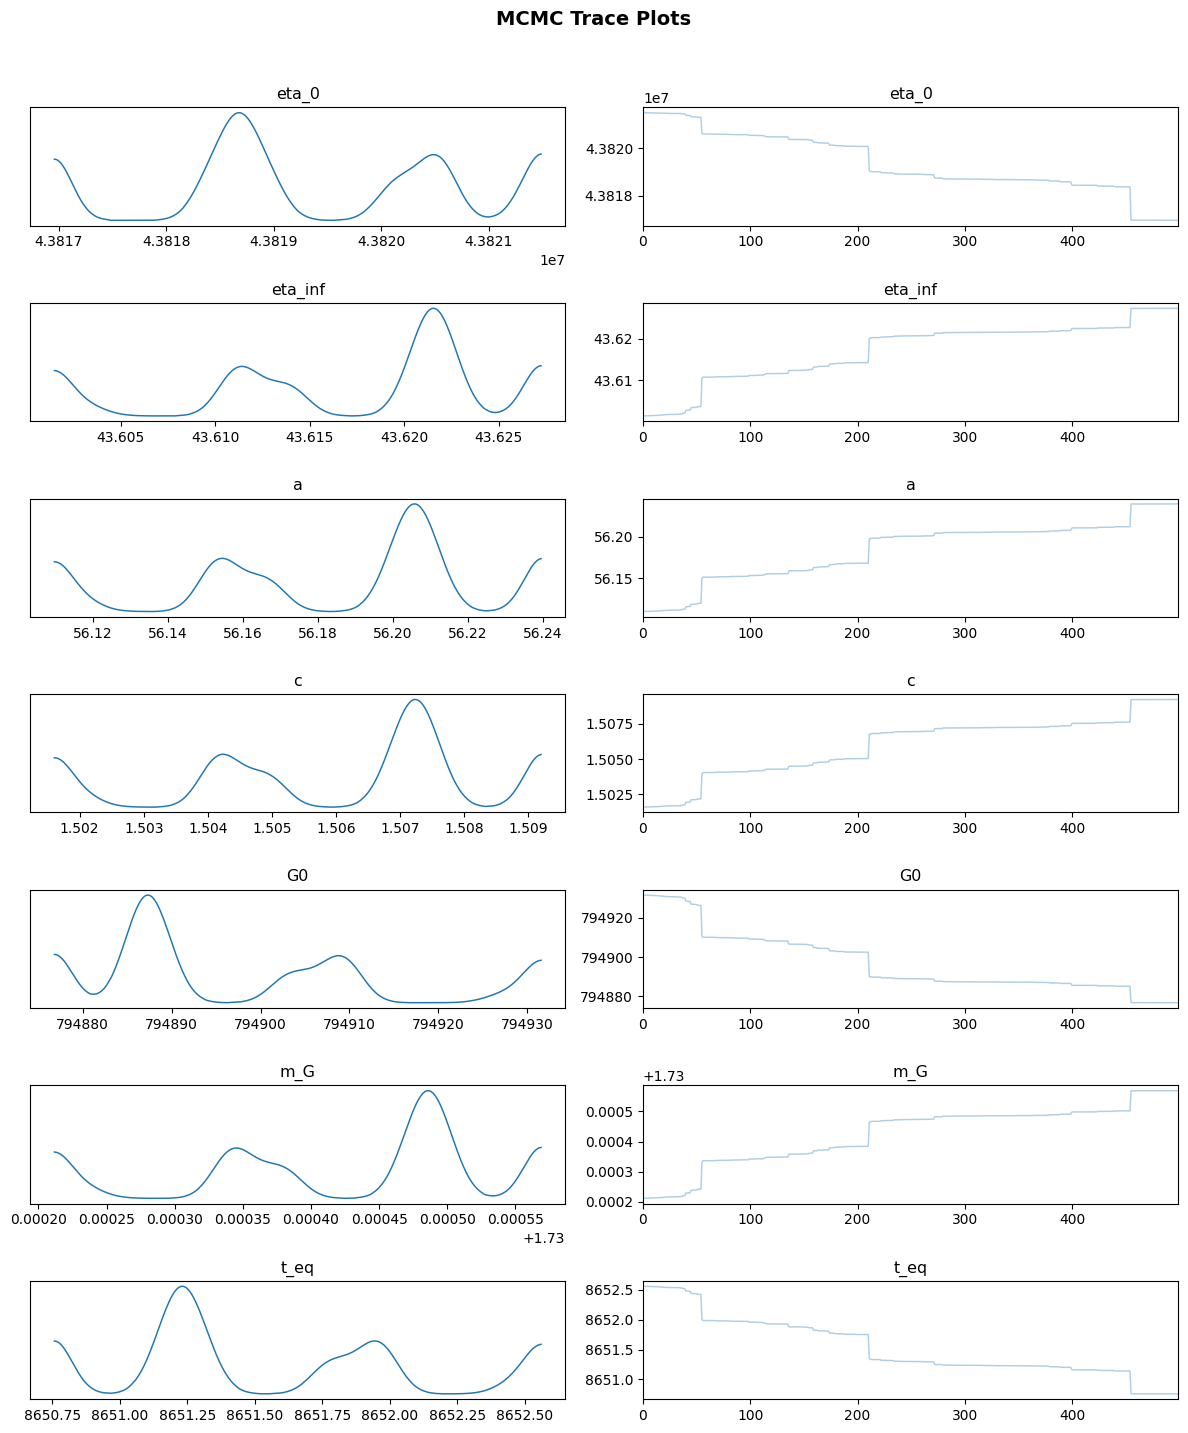

In [12]:
# Trace plot
calib_param_names = list(calib_params.keys())
az.plot_trace(idata, var_names=calib_param_names)
fig = plt.gcf()
fig.suptitle("MCMC Trace Plots", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

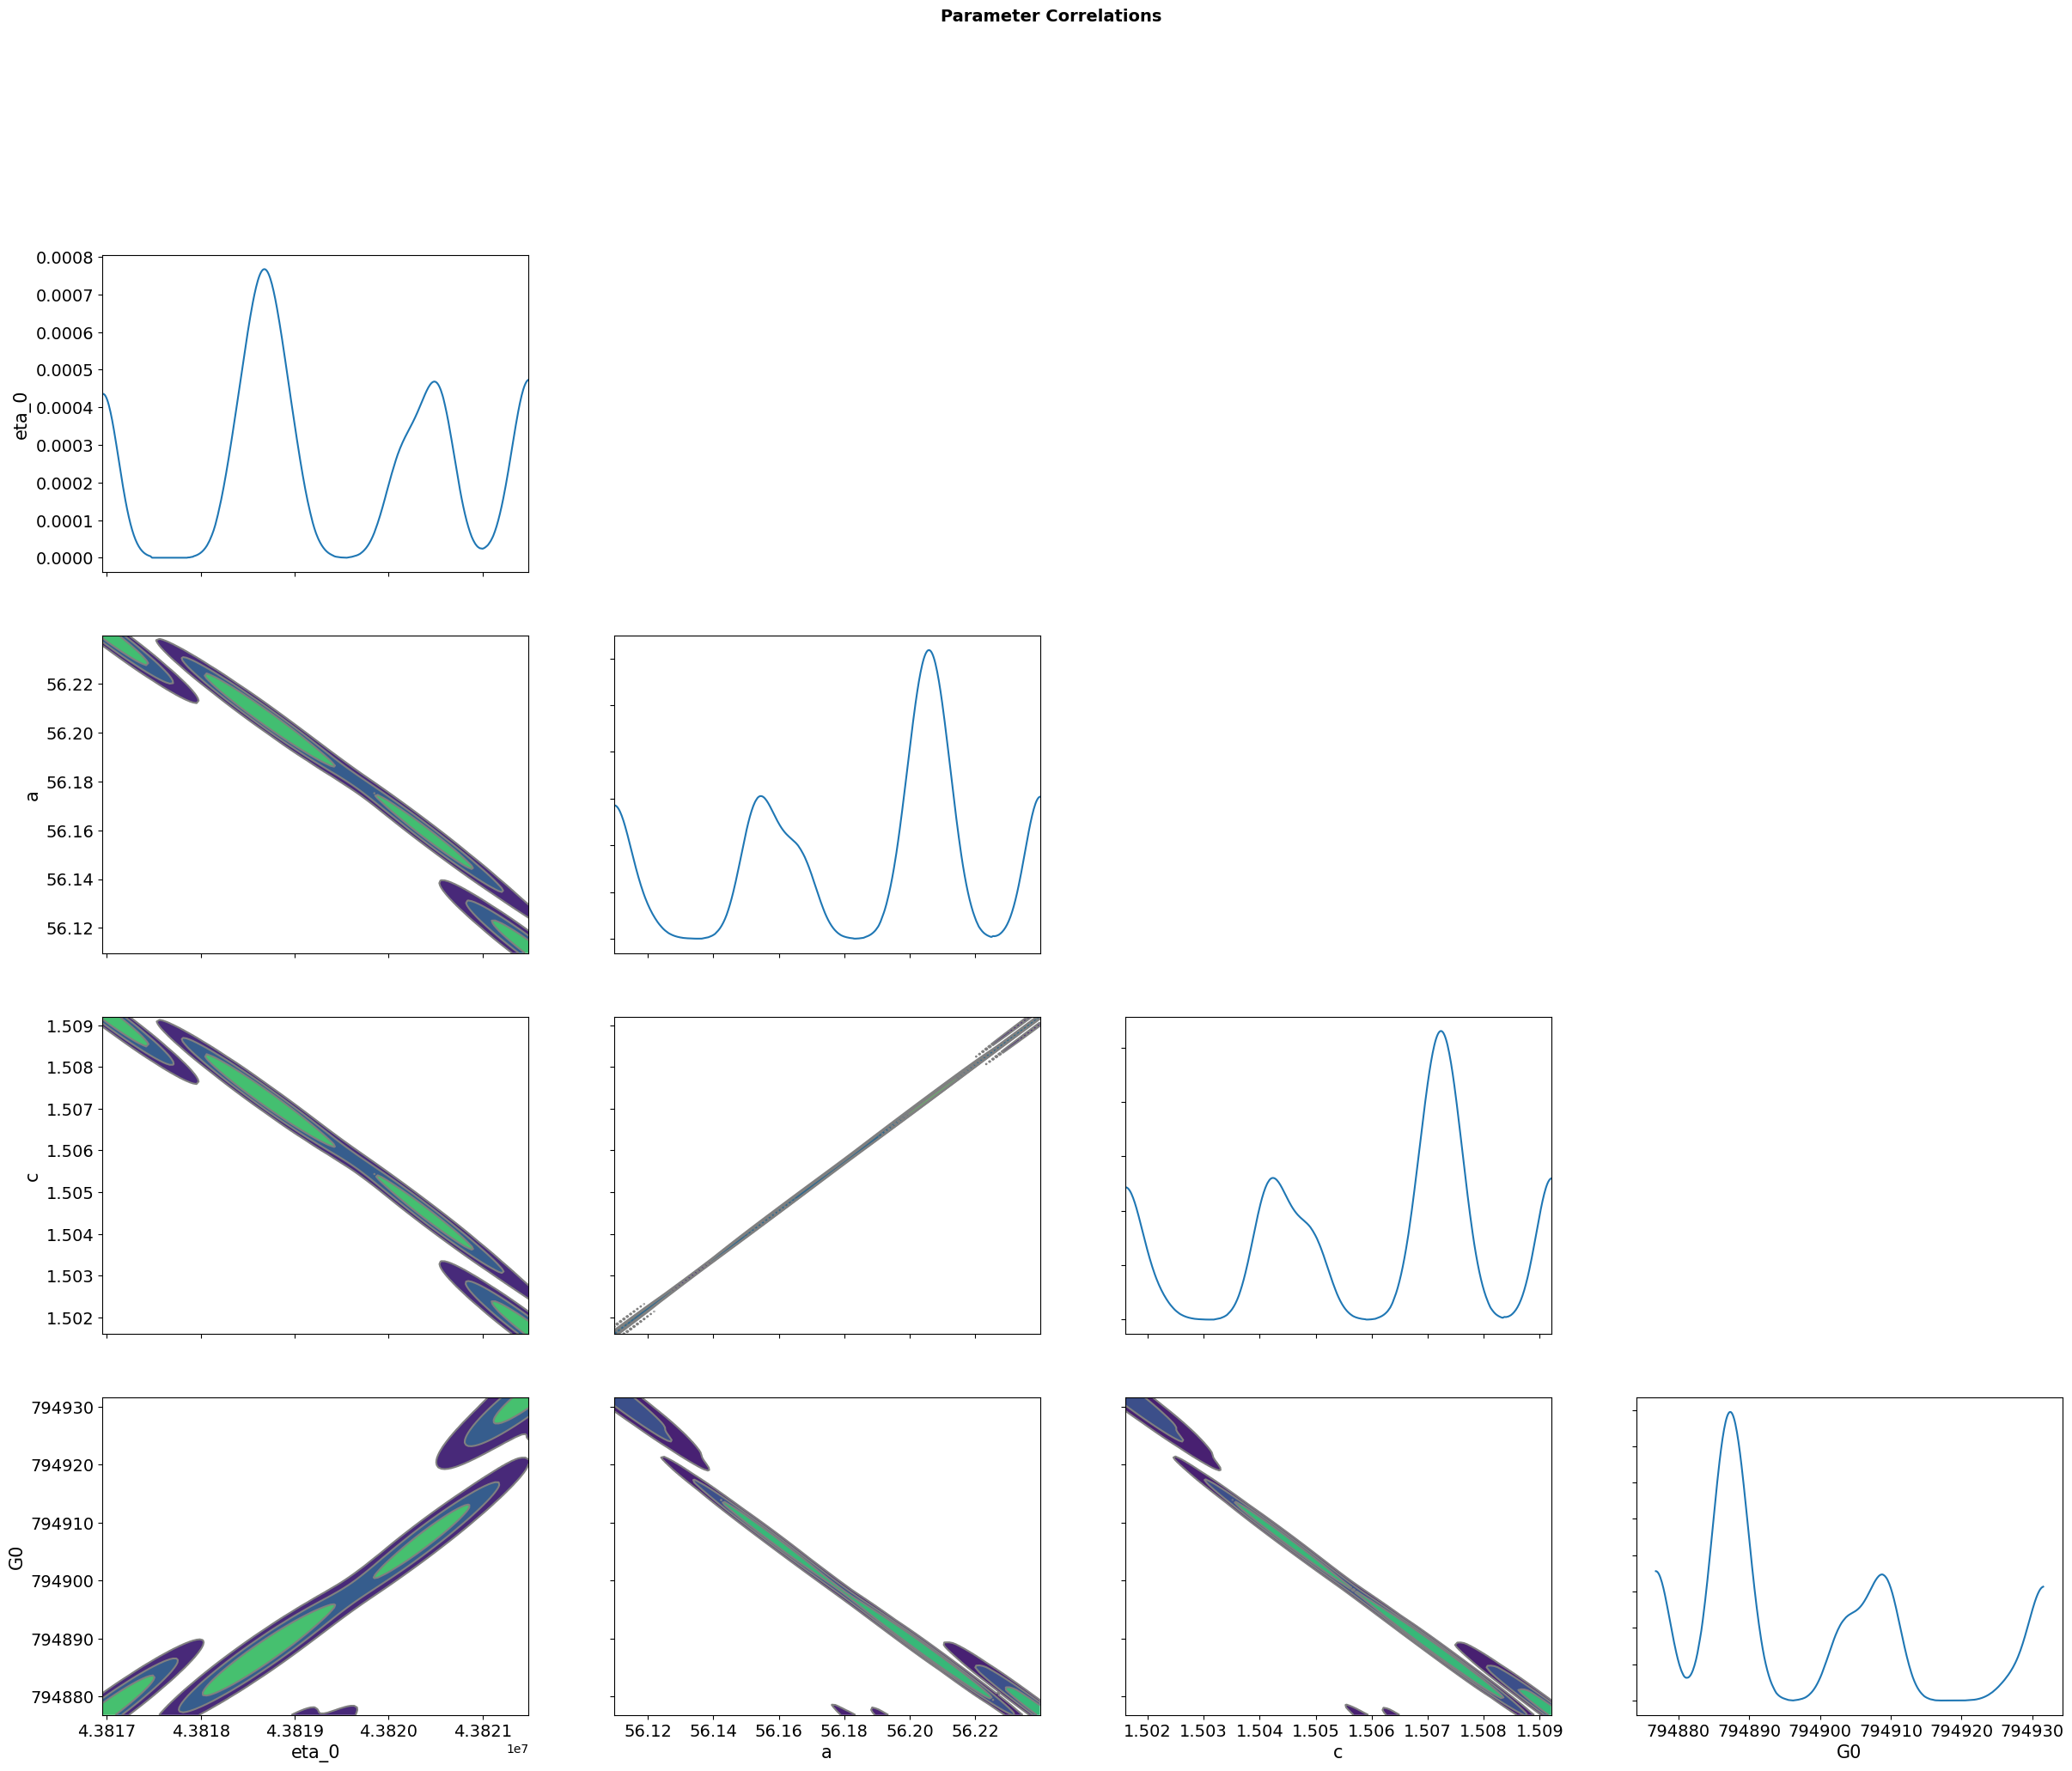

In [13]:
# Pair plot (parameter correlations)
az.plot_pair(
    idata,
    var_names=["eta_0", "a", "c", "G0"],
    kind="kde",
    divergences=False,
    marginals=True,
)
fig = plt.gcf()
fig.suptitle("Parameter Correlations", fontsize=14, fontweight="bold", y=1.01)
display(fig)
plt.close(fig)

### Posterior Predictive Check

In [14]:
# Draw posterior samples and simulate
n_draws = 100
param_names = list(calib_params.keys())

# Flatten posterior samples (single chain)
posterior_flat = {name: result_bayes.posterior_samples[name].flatten() for name in param_names}

# Random draws
indices = np.random.choice(len(posterior_flat[param_names[0]]), size=n_draws, replace=False)

predictions = []
for idx in indices:
    # Create model with posterior parameters
    model_post = DMTLocal(closure="exponential", include_elasticity=True)
    for name in param_names:
        model_post.parameters[name].value = float(posterior_flat[name][idx])
    
    # Simulate using the model's simulate_startup method
    t_sim, stress_sim, _ = model_post.simulate_startup(
        gamma_dot=gamma_dot_fit,
        t_end=t_end,
        dt=dt,
    )
    predictions.append(stress_sim)

predictions = jnp.array(predictions)

# Compute median and 95% CI
median_pred = jnp.median(predictions, axis=0)
lower_pred = jnp.percentile(predictions, 2.5, axis=0)
upper_pred = jnp.percentile(predictions, 97.5, axis=0)

print(f"Posterior predictive: {n_draws} samples")

Posterior predictive: 100 samples


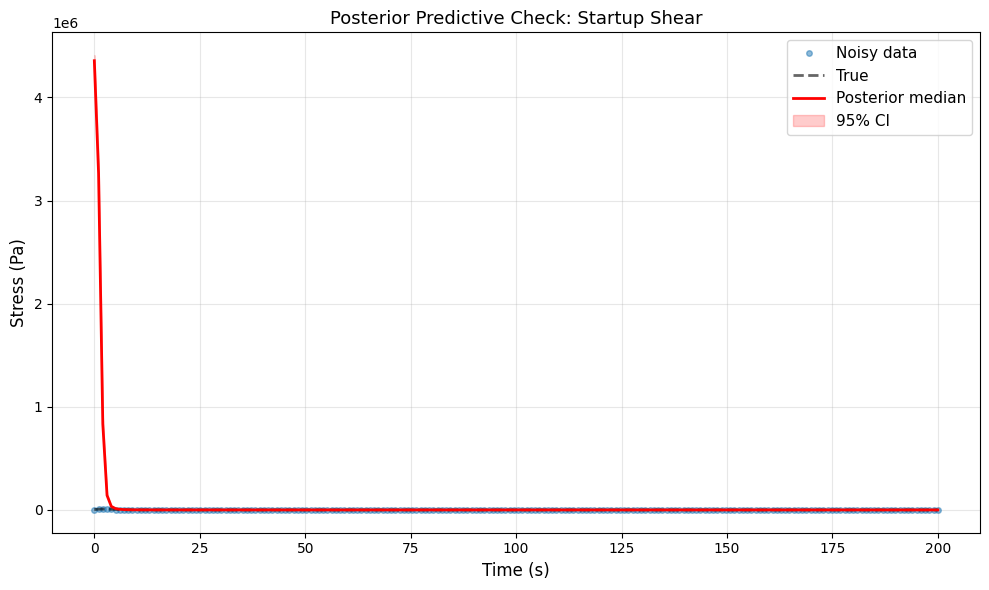

In [15]:
# Plot posterior predictive
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_fit, stress_fit, "o", markersize=4, alpha=0.5, label="Noisy data")
ax.plot(t_fit, data_fit["stress"], "k--", linewidth=2, alpha=0.6, label="True")
ax.plot(t_sim, median_pred, "r-", linewidth=2, label="Posterior median")
ax.fill_between(
    t_sim,
    lower_pred,
    upper_pred,
    color="red",
    alpha=0.2,
    label="95% CI",
)

ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Stress (Pa)", fontsize=12)
ax.set_title("Posterior Predictive Check: Startup Shear", fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## Physics Analysis

### Stress Overshoot Ratio vs Shear Rate

In [16]:
# Compute overshoot ratio for each shear rate
overshoot_ratios = []

for gamma_dot in gamma_dots:
    data = startup_data[float(gamma_dot)]
    stress = data["stress"]
    
    # Peak stress
    sigma_peak = jnp.max(stress)
    
    # Steady-state stress (average of last 10%)
    n_ss = int(len(stress) * 0.1)
    sigma_ss = jnp.mean(stress[-n_ss:])
    
    # Overshoot ratio
    ratio = sigma_peak / sigma_ss
    overshoot_ratios.append(ratio)
    
    print(f"γ̇ = {gamma_dot:>6.1f} s⁻¹:  σ_peak = {sigma_peak:>8.2f} Pa,  σ_ss = {sigma_ss:>8.2f} Pa,  Ratio = {ratio:.3f}")

overshoot_ratios = jnp.array(overshoot_ratios)

γ̇ =    0.1 s⁻¹:  σ_peak =   678.07 Pa,  σ_ss =   345.55 Pa,  Ratio = 1.962
γ̇ =    1.0 s⁻¹:  σ_peak =  2899.68 Pa,  σ_ss =   122.93 Pa,  Ratio = 23.587
γ̇ =   10.0 s⁻¹:  σ_peak =  8907.40 Pa,  σ_ss =    26.01 Pa,  Ratio = 342.466
γ̇ =  100.0 s⁻¹:  σ_peak = 11762.82 Pa,  σ_ss =    50.10 Pa,  Ratio = 234.768


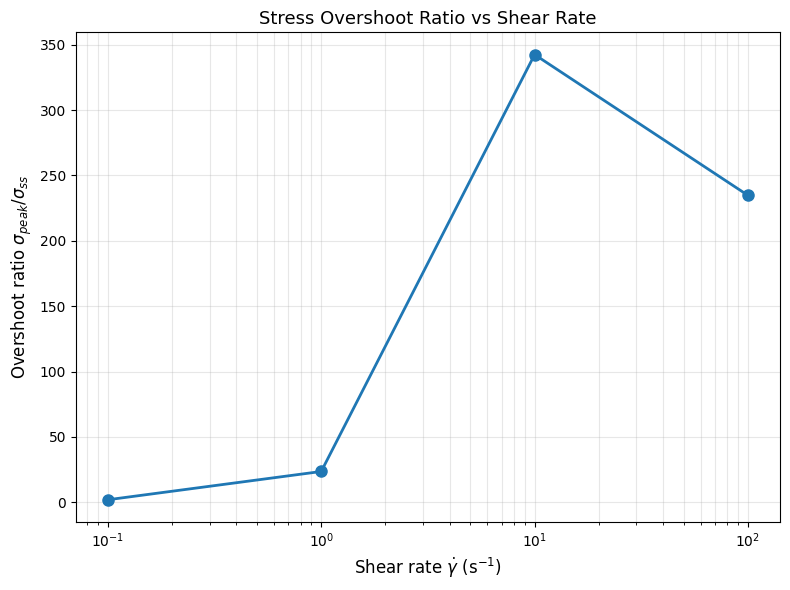

In [17]:
# Plot overshoot ratio vs shear rate
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(gamma_dots, overshoot_ratios, "o-", markersize=8, linewidth=2)

ax.set_xscale("log")
ax.set_xlabel("Shear rate $\\dot{\\gamma}$ (s$^{-1}$)", fontsize=12)
ax.set_ylabel("Overshoot ratio $\\sigma_{peak}/\\sigma_{ss}$", fontsize=12)
ax.set_title("Stress Overshoot Ratio vs Shear Rate", fontsize=13)
ax.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

### Structure Breakdown Dynamics

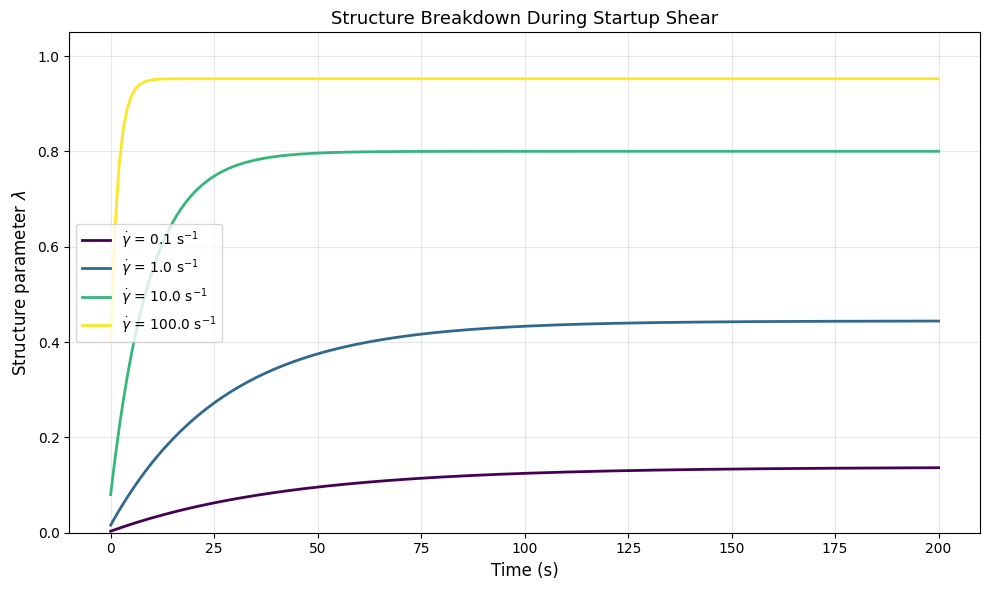

In [18]:
# Plot structure parameter λ(t) for all shear rates
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_dots)))

for idx, gamma_dot in enumerate(gamma_dots):
    data = startup_data[float(gamma_dot)]
    lambda_t = 1.0 - data["fluidity"]  # λ = 1 - f
    
    ax.plot(
        data["t"],
        lambda_t,
        "-",
        linewidth=2,
        color=colors[idx],
        label=f"$\\dot{{\\gamma}}$ = {gamma_dot:.1f} s$^{{-1}}$",
    )

ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Structure parameter $\\lambda$", fontsize=12)
ax.set_title("Structure Breakdown During Startup Shear", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])

plt.tight_layout()
display(fig)
plt.close(fig)

### Role of Maxwell Elasticity

Compare DMT-Maxwell (with overshoot) vs DMT-Viscous (monotonic approach).

In [19]:
# Create DMT model WITHOUT elasticity
model_viscous = DMTLocal(closure="exponential", include_elasticity=False)

# Set same parameters (G0 and m_G are unused)
for name, value in calib_params.items():
    if name in ["G0", "m_G"]:
        continue
    model_viscous.parameters[name].value = value

# Simulate startup at γ̇ = 10.0
t_visc, stress_visc, _ = model_viscous.simulate_startup(
    gamma_dot=10.0,
    t_end=t_end,
    dt=dt,
)

print("Simulated DMT-Viscous (no elasticity) startup")

Simulated DMT-Viscous (no elasticity) startup


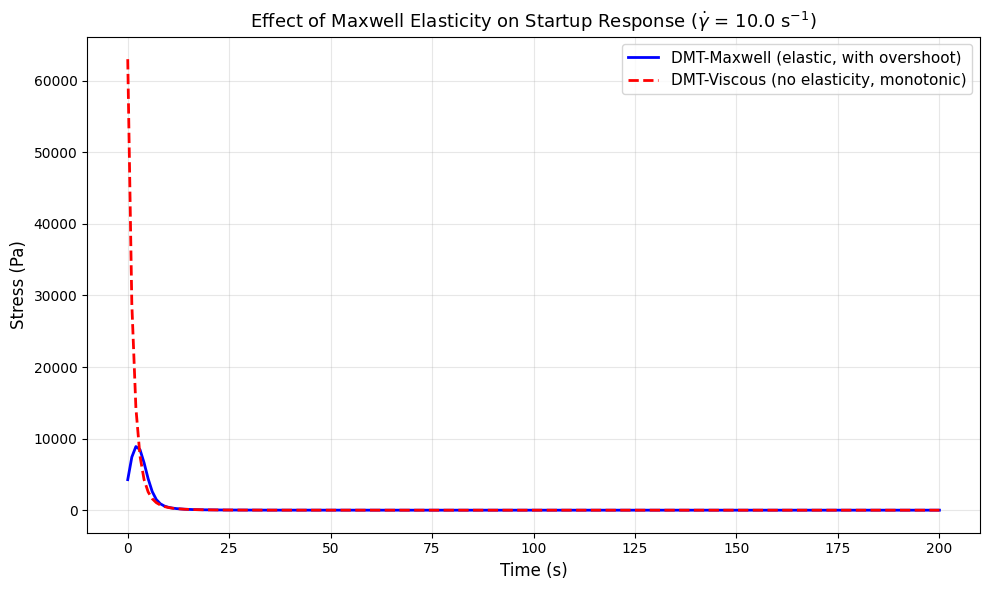

In [20]:
# Compare Maxwell vs Viscous
data_maxwell = startup_data[10.0]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(
    data_maxwell["t"],
    data_maxwell["stress"],
    "b-",
    linewidth=2,
    label="DMT-Maxwell (elastic, with overshoot)",
)
ax.plot(
    t_visc,
    stress_visc,
    "r--",
    linewidth=2,
    label="DMT-Viscous (no elasticity, monotonic)",
)

ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Stress (Pa)", fontsize=12)
ax.set_title("Effect of Maxwell Elasticity on Startup Response ($\\dot{\\gamma}$ = 10.0 s$^{-1}$)", fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## Save Results

In [21]:
# Create output directory
output_dir = Path("examples/outputs/dmt/startup")
output_dir.mkdir(parents=True, exist_ok=True)

# Save overshoot analysis
overshoot_file = output_dir / "overshoot_analysis.npz"
np.savez(
    overshoot_file,
    gamma_dots=np.array(gamma_dots),
    overshoot_ratios=np.array(overshoot_ratios),
)

print(f"Saved overshoot analysis to {overshoot_file}")

# Save fitted parameters
params_file = output_dir / "fitted_parameters.txt"
with open(params_file, "w") as f:
    f.write("DMT Startup Shear - Fitted Parameters\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Shear rate: {gamma_dot_fit} s⁻¹\n")
    f.write(f"NLSQ R²: {metrics['R2']:.6f}\n\n")
    f.write(f"{'Parameter':<10} {'Value':>12} {'Unit':>10}\n")
    f.write("-" * 35 + "\n")
    for name, param in model_fit.parameters.items():
        f.write(f"{name:<10} {param.value:>12.4g} {'-':>10}\n")

print(f"Saved fitted parameters to {params_file}")

# Save posterior samples
posterior_file = output_dir / "posterior_samples.npz"
np.savez(posterior_file, **{k: np.array(v) for k, v in result_bayes.posterior_samples.items()})

print(f"Saved posterior samples to {posterior_file}")

Saved overshoot analysis to examples/outputs/dmt/startup/overshoot_analysis.npz
Saved fitted parameters to examples/outputs/dmt/startup/fitted_parameters.txt
Saved posterior samples to examples/outputs/dmt/startup/posterior_samples.npz


## Key Takeaways

### 1. Stress Overshoot Mechanism
- **Maxwell elasticity required**: Stress overshoot only occurs with elastic storage (`include_elasticity=True`)
- **Viscous models**: Without elasticity, stress increases monotonically to steady state
- **Competition**: Overshoot arises from elastic loading competing with viscous relaxation

### 2. Shear Rate Dependence
- **Overshoot ratio increases with $\\dot{\\gamma}$**: Higher shear rates → larger peaks
- **Physical interpretation**: Faster loading outpaces structure breakdown initially
- **Typical values**: Overshoot ratio ~ 1.1-1.3 for soft materials

### 3. Structure Breakdown Timescale
- **Characteristic time**: $t_{break} \\sim 1/(a \\cdot \\dot{\\gamma}^c)$
- **Faster at high $\\dot{\\gamma}$**: Structure parameter $\\lambda$ decays more rapidly
- **Steady state**: $\\lambda_{ss}$ decreases with shear rate (more rejuvenation)

### 4. Bayesian Workflow
- **NLSQ warm-start**: Critical for convergence in transient protocols
- **Parameter correlations**: $\\eta_0$ and $G_0$ are typically correlated (set overshoot magnitude)
- **Posterior predictive**: 95% CI captures data within noise level

### 5. Experimental Signatures
- **Thixotropic materials**: Stress overshoot is hallmark signature
- **Examples**: Emulsions, suspensions, gels, biological fluids
- **Quantification**: Overshoot ratio and time-to-peak are key metrics